In [1]:
import sys
import os
import cv2
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
from measure import compute_psnr, compute_ssim

In [2]:
class GuidedFilter:
    def __init__(self, I, radius=5, epsilon=0.4):

        self._radius = 2 * radius + 1
        self._epsilon = epsilon
        self._I = self._toFloatImg(I)
        self._initFilter()

    def _toFloatImg(self, img):
        if img.dtype == np.float32:
            return img
        return ( 1.0 / 255.0 ) * np.float32(img)
    
    def _initFilter(self):
        I = self._I
        r = self._radius
        eps = self._epsilon

        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]

        self._Ir_mean = cv2.blur(Ir, (r, r))
        self._Ig_mean = cv2.blur(Ig, (r, r))
        self._Ib_mean = cv2.blur(Ib, (r, r))

        Irr_var = cv2.blur(Ir ** 2, (r, r)) - self._Ir_mean ** 2 + eps                                       
        Irg_var = cv2.blur(Ir * Ig, (r, r)) - self._Ir_mean * self._Ig_mean                                  
        Irb_var = cv2.blur(Ir * Ib, (r, r)) - self._Ir_mean * self._Ib_mean                                  
        Igg_var = cv2.blur(Ig * Ig, (r, r)) - self._Ig_mean * self._Ig_mean + eps                            
        Igb_var = cv2.blur(Ig * Ib, (r, r)) - self._Ig_mean * self._Ib_mean                                  
        Ibb_var = cv2.blur(Ib * Ib, (r, r)) - self._Ib_mean * self._Ib_mean + eps                                                                                     

        Irr_inv = Igg_var * Ibb_var - Igb_var * Igb_var                                                      
        Irg_inv = Igb_var * Irb_var - Irg_var * Ibb_var                                                      
        Irb_inv = Irg_var * Igb_var - Igg_var * Irb_var                                                      
        Igg_inv = Irr_var * Ibb_var - Irb_var * Irb_var                                                      
        Igb_inv = Irb_var * Irg_var - Irr_var * Igb_var                                                      
        Ibb_inv = Irr_var * Igg_var - Irg_var * Irg_var                                                      
        
        I_cov = Irr_inv * Irr_var + Irg_inv * Irg_var + Irb_inv * Irb_var                                    
        Irr_inv /= I_cov                                                                                     
        Irg_inv /= I_cov                                                                                     
        Irb_inv /= I_cov                                                                                     
        Igg_inv /= I_cov                                                                                     
        Igb_inv /= I_cov                                                                                     
        Ibb_inv /= I_cov                                                                                     
        
        self._Irr_inv = Irr_inv                                                                              
        self._Irg_inv = Irg_inv                                                                              
        self._Irb_inv = Irb_inv                                                                              
        self._Igg_inv = Igg_inv                                                                              
        self._Igb_inv = Igb_inv                                                                              
        self._Ibb_inv = Ibb_inv                  

    def _computeCoefficients(self, p):
        r = self._radius                                                             
        I = self._I                                                                 
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]                                                          
        

        p_mean = cv2.blur(p, (r, r))                             
        Ipr_mean = cv2.blur(Ir * p, (r, r))                                                         
        Ipg_mean = cv2.blur(Ig * p, (r, r))                                                    
        Ipb_mean = cv2.blur(Ib * p, (r, r))             



        Ipr_cov = Ipr_mean - self._Ir_mean * p_mean                                                 
        Ipg_cov = Ipg_mean - self._Ig_mean * p_mean                                                     
        Ipb_cov = Ipb_mean - self._Ib_mean * p_mean                                                       
                                                                                                                 
        ar = self._Irr_inv * Ipr_cov + self._Irg_inv * Ipg_cov + self._Irb_inv * Ipb_cov                 
        ag = self._Irg_inv * Ipr_cov + self._Igg_inv * Ipg_cov + self._Igb_inv * Ipb_cov                
        ab = self._Irb_inv * Ipr_cov + self._Igb_inv * Ipg_cov + self._Ibb_inv * Ipb_cov    

        b = p_mean - ar * self._Ir_mean - ag * self._Ig_mean - ab * self._Ib_mean                                                                                                                                         

        ar_mean = cv2.blur(ar, (r, r))          
        ag_mean = cv2.blur(ag, (r, r))                                                                   
        ab_mean = cv2.blur(ab, (r, r))                                                                      
        b_mean = cv2.blur(b, (r, r))                                                                                                                                              

        return ar_mean, ag_mean, ab_mean, b_mean            

    def _computeOutput(self, ab, I):
    
        ar_mean, ag_mean, ab_mean, b_mean = ab
        Ir, Ig, Ib = I[:, :, 0], I[:, :, 1], I[:, :, 2]
        q = ar_mean * Ir + ag_mean * Ig + ab_mean * Ib + b_mean
        return q

    def filter(self, p):        
        coef = self._computeCoefficients(p)
        return self._computeOutput(coef, self._I)

In [3]:
def extract_depth_map(I, config):

    hsvI = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    s = hsvI[:,:,1] / 255.0
    v = hsvI[:,:,2] / 255.0

    sigma = 0.041337
    sigmaMat = np.random.normal(0, sigma, (I.shape[0], I.shape[1]))
    
    output = config['theta_0'] + config['theta_1'] * v + config['theta_2'] * s + sigmaMat

    outputPixel = output
    r = config['r']
    output = scipy.ndimage.filters.minimum_filter(output,(r,r))
    outputRegion = output
    
    return outputRegion, outputPixel

def estimate_atmospheric(img, Jdark):
    """
    estimate A by given a threshold
    """
    h,w,c = img.shape
    if img.dtype == np.uint8:
        img = np.float32(img) / 255
    
    # Compute number for 0.1% brightest pixels
    n_bright = int(np.ceil(0.001*h*w))
    #  Loc contains the location of the sorted pixels
    reshaped_Jdark = Jdark.reshape(1,-1)
    Y = np.sort(reshaped_Jdark) 
    Loc = np.argsort(reshaped_Jdark)
    
    # column-stacked version of I
    Ics = img.reshape(1, h*w, 3)
    ix = img.copy()
    dx = Jdark.reshape(1,-1)
    
    # init a matrix to store candidate airlight pixels
    Acand = np.zeros((1, n_bright, 3), dtype=np.float32)
    # init matrix to store largest norm arilight
    Amag = np.zeros((1, n_bright, 1), dtype=np.float32)
    
    # Compute magnitudes of RGB vectors of A
    for i in range(n_bright):
        x = Loc[0,h*w-1-i]
        ix[x//w, x%w, 0] = 0
        ix[x//w, x%w, 1] = 0
        ix[x//w, x%w, 2] = 1
        
        Acand[0, i, :] = Ics[0, Loc[0, h*w-1-i], :]
        Amag[0, i] = np.linalg.norm(Acand[0,i,:])
    
    # Sort A magnitudes
    reshaped_Amag = Amag.reshape(1,-1)
    Y2 = np.sort(reshaped_Amag) 
    Loc2 = np.argsort(reshaped_Amag)
    # A now stores the best estimate of the airlight
    if len(Y2) > 20:
        A = Acand[0, Loc2[0, n_bright-19:n_bright],:]
    else:
        A = Acand[0, Loc2[0,n_bright-len(Y2):n_bright],:]
        
    return A

In [4]:
def recover(I, transmission):
    if I.dtype == np.uint8:
        I = np.float32(I) / 255

    h,w,c = I.shape
    J = np.zeros((h, w, c), dtype=np.float32)

    J[:,:,0] = I[:,:,0] - a[0,0]
    J[:,:,1] = I[:,:,1] - a[0,1]
    J[:,:,2] = I[:,:,2] - a[0,2]
    
    t0, t1 = 0.05, 1
    transmission = transmission.clip(t0, t1)

    J[:, :, 0] = J[:, :, 0]  / transmission
    J[:, :, 1] = J[:, :, 1]  / transmission
    J[:, :, 2] = J[:, :, 2]  / transmission

    J[:, :, 0] = J[:, :, 0]  + a[0, 0]
    J[:, :, 1] = J[:, :, 1]  + a[0, 1]
    J[:, :, 2] = J[:, :, 2]  + a[0, 2]
    
    J = J*255
    J = J.astype(int)
    return J

In [5]:
haze_path = '../../data/aerial.png'
# haze_path = '../../data/input_cap.png'

In [6]:
config = {}
config['r'] = 15 
config['beta'] = 1.0
config['gimfiltR'] = 60 
config['eps'] = 1e-3
config['theta_0'] = 0.121779
config['theta_1'] = 0.959710
config['theta_2'] = -0.780245

In [7]:
I = cv2.imread(haze_path)
dR,dP = extract_depth_map(I, config)

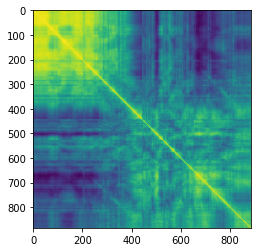

In [101]:
hsvI = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
s = hsvI[:,:,1]
v = hsvI[:,:,2]
diff_sv = np.corrcoef(v,s)
plt.imshow(diff_sv)

In [95]:
diff_sv[:50,550:]

array([[ 0.07473012,  0.09182515,  0.0926608 , ..., -0.31847964,
        -0.29455843, -0.25051049],
       [ 0.07783208,  0.09540732,  0.0948194 , ..., -0.33510836,
        -0.30625383, -0.25763684],
       [ 0.0675822 ,  0.08806523,  0.09297841, ..., -0.35132377,
        -0.32062983, -0.2736344 ],
       ...,
       [ 0.0932188 ,  0.11061786,  0.10658842, ..., -0.38326508,
        -0.36509528, -0.31220738],
       [ 0.09427354,  0.11545656,  0.11726816, ..., -0.38097618,
        -0.3599251 , -0.31348709],
       [ 0.0772003 ,  0.10201786,  0.11512362, ..., -0.39360976,
        -0.36360708, -0.32036513]])

In [10]:
guided_filter = GuidedFilter(I, config['gimfiltR'], config['eps'])
refineDR = guided_filter.filter(dR)

## tR is the medium transmission 
tR = np.exp(-config['beta'] * refineDR)
a = atmospheric_scatter(I, dR)

NameError: name 'atmospheric_scatter' is not defined

In [ ]:
plt.imshow(recover(I, tR))